# `PHAS0102 Assignment 1 - matrix-matrix multiplication`

In [25]:
import matplotlib.pyplot as plt
import numba
from numba import jit, njit, prange
import numpy as np
from timeit import timeit
from tqdm import tqdm

Components, $c_{ij}$ of the matrix product $C$ of two matrices $A$ and $B$, where $A,B \in \mathbb{R}^{n \times n}$, are given by:  
$$c_{ij}=\sum_{k=1}^n a_{ik}b_{kj}$$  
A function that computes this product is given below. This function has large compute times due to its unoptimised structure, including three nested loops and list appending. This notebook provides methods to optimise this function and reduce compute times.

In [3]:
def slow_matrix_product(matrix_1, matrix_2):
    """description : multiply two matrices using three nested loops"""

    # ensure matrices have compatible dimensions - for matrix multiplication, number of columns in first matrix must be equal to number of rows on second matrix
    assert matrix_1.shape[1] == matrix_2.shape[0]

    result = [] # initialise list for storing values

    # loop through columns 
    for c in range(matrix_2.shape[1]):
        column = []

        # loop through rows
        for r in range(matrix_1.shape[0]):
            value = 0 # accumulator for dot product between row and column

            # dot product between row and column
            for i in range(matrix_1.shape[1]):
                value += matrix_1[r, i] * matrix_2[i, c]

            # append value to column    
            column.append(value)

        # append column to matrix
        result.append(column)

    # ensure matrix is of correct dimensions
    return np.array(result).transpose()

## `part 1: a better function`
In this section, we will optimise the above function using only `NumPy`, and compare compute speeds of this optimised function with the slower, unoptimised function.

In [4]:
def faster_matrix_product(matrix_1, matrix_2):
    """multiply two matrices faster"""

    # ensure matrices have compatible dimensions - for matrix multiplication, number of columns in first matrix must be equal to number of rows on second matrix
    assert matrix_1.shape[1] == matrix_2.shape[0]
    dt = matrix_1.dtype

    # pre-allocate empty array for result to improve performance
    result = np.empty((matrix_1.shape[0], matrix_2.shape[1]), dtype=dt)

    # transpose second matrix, so columns can be accessed as rows
    matrix_2_T = matrix_2.T

    # loop through each row and column of matrix 1 and 2
    for r in range(matrix_1.shape[0]):
        for c in range(matrix_2.shape[1]):

            # compute dot product of row and column
            value = np.dot(matrix_1[r,:], matrix_2_T[c,:])
            result[r,c] = value

    return result

### `checking function works`

In [10]:
def check_function(matrix_product_function):
    """check function works"""
    for i in range(2, 6):
        mat1 = np.random.rand(i,i)
        mat2 = np.random.rand(i,i)
        assert np.allclose(mat1@mat2, matrix_product_function(mat1, mat2))
    print(f'! {matrix_product_function.__name__} works for 2x2 to 5x5 matrices !')

In [11]:
check_function(faster_matrix_product)

! faster_matrix_product works for 2x2 to 5x5 matrices !


### `speed comparison`
Here, we will compare compute speeds for the `slow_matrix_product`, `faster_matrix_product` and `NumPy` matrix multiplication methods using `timeit`. Compute times will be plotted against matrix sizes on a log scale.

In [15]:
matrix_sizes = np.arange(50,800,75)

slow_times = []
fast_times = []
numpy_times = []

for i in tqdm(matrix_sizes):
    matrix1 = np.random.rand(i,i)
    matrix2 = np.random.rand(i,i)

    slow_times.append(timeit(lambda: slow_matrix_product(matrix1, matrix2), globals=globals(), number=5))
    fast_times.append(timeit(lambda: faster_matrix_product(matrix1, matrix2), globals=globals(), number=5))
    numpy_times.append(timeit(lambda: matrix1@matrix2, globals=globals(), number=5))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [27:26<00:00, 164.65s/it]


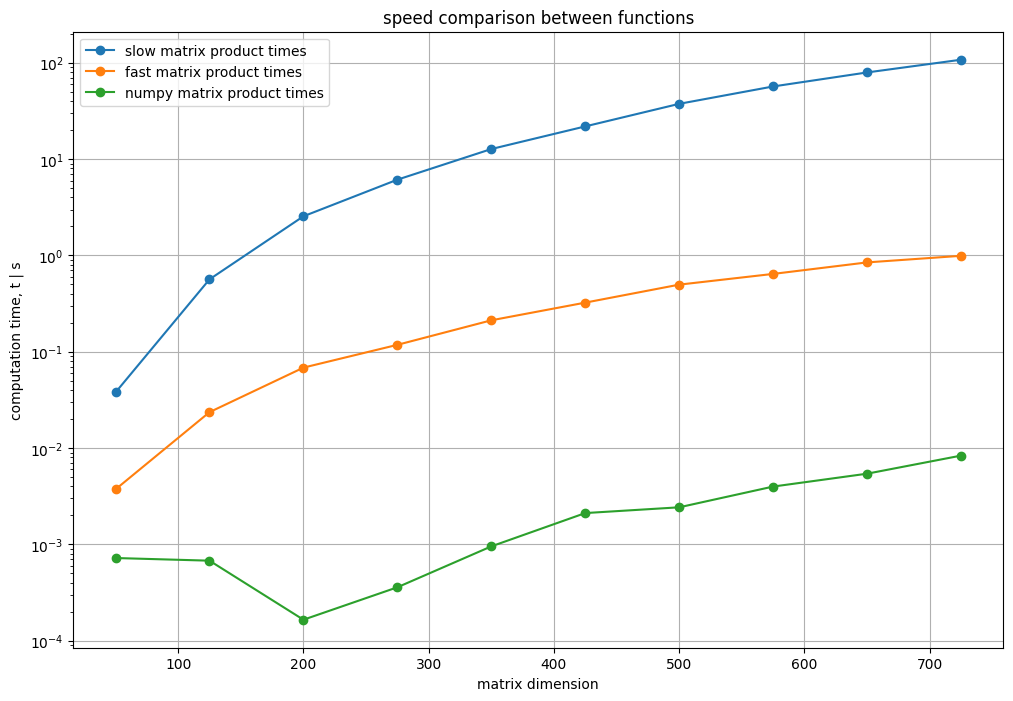

In [16]:
plt.figure(figsize=(12,8))
plt.title('speed comparison between functions')
plt.ylabel('computation time, t | s')
plt.xlabel('matrix dimension')

plt.plot(matrix_sizes, np.array(slow_times)/5, '-o', label='slow matrix product times')
plt.plot(matrix_sizes, np.array(fast_times)/5, '-o', label='fast matrix product times')
plt.plot(matrix_sizes, np.array(numpy_times)/5, '-o', label='numpy matrix product times')

plt.grid()
plt.legend()
plt.yscale('log')

- `faster_matrix_product` uses two `for` loops, as opposed to the three used in `slow_matrix_product`, thus lowering time complexity from $O(n^3)$ to between $O(n^2)$ and $O(n^3)$, decreasing the time taken for computation.  
- `faster_matrix_product` also uses `np.dot` to calculate matrix components as opposed to individually multiplying components. NumPy uses Basic Linear Algebra Subprograms and Linear Algebra Package to optimise these math operations.

## `part 2: speeding up w/ Numba`
`Numba` is a python library that allows code to be compiled to optimised CPU machine code using the LLVM infrastructure, optimising memory access and allowing parallel loop execution. Using these tools allows code to reach C/Fortran execution times.

In [24]:
# wrapping with Numba JIT compiling, 
@njit(['float64[:,:](float64[:,:],float64[:,:])'],parallel=True)
def faster_matrix_product_njit(matrix_1, matrix_2):
    """multiply two matrices faster, using Numba's Just In Time compilation"""

    # ensure matrices have compatible dimensions - for matrix multiplication, number of columns in first matrix must be equal to number of rows on second matrix
    assert matrix_1.shape[1] == matrix_2.shape[0]
    dt = matrix_1.dtype

    # pre-allocate empty array for result to improve performance
    result = np.empty((matrix_1.shape[0], matrix_2.shape[1]), dtype=dt)
    
    # transpose second matrix, so columns can be accessed as rows
    matrix_2_T = matrix_2.T

    # use Numba's prange to parallelise outer loop across CPU threads
    for r in prange(matrix_1.shape[0]):
        for c in range(matrix_2_T.shape[0]):

            # compute dot product of row and column
            value = np.dot(matrix_1[r,:], matrix_2_T[c,:])
            result[r,c] = value

    return result  

In [18]:
# initialising jit compiled functions
init_mat1 = np.random.rand(3,3)
init_mat2 = np.random.rand(3,3)
njit_init = timeit(lambda: faster_matrix_product(init_mat1, init_mat2), globals=globals(), number=1)

### `checking function works`

In [19]:
check_function(faster_matrix_product_njit)

! faster_matrix_product_njit works for 2x2 to 5x5 matrices !


### `speed comparison`
Here we will add compute times of the JIT compiled matrix multiplication function to our comparison graph from earlier.

In [20]:
matrix_sizes_2 = np.arange(50,1100,50)

fast_times_2 = []
njit_times_2 = []
numpy_times_2 = []

for i in tqdm(matrix_sizes_2):
    matrix1 = np.random.rand(i,i)
    matrix2 = np.random.rand(i,i)

    fast_times_2.append(timeit(lambda: faster_matrix_product(matrix1, matrix2), globals=globals(), number=8))
    njit_times_2.append(timeit(lambda:faster_matrix_product_njit(matrix1, matrix2), globals=globals(), number=8))
    numpy_times_2.append(timeit(lambda: matrix1@matrix2, globals=globals(), number=8))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [02:54<00:00,  8.33s/it]


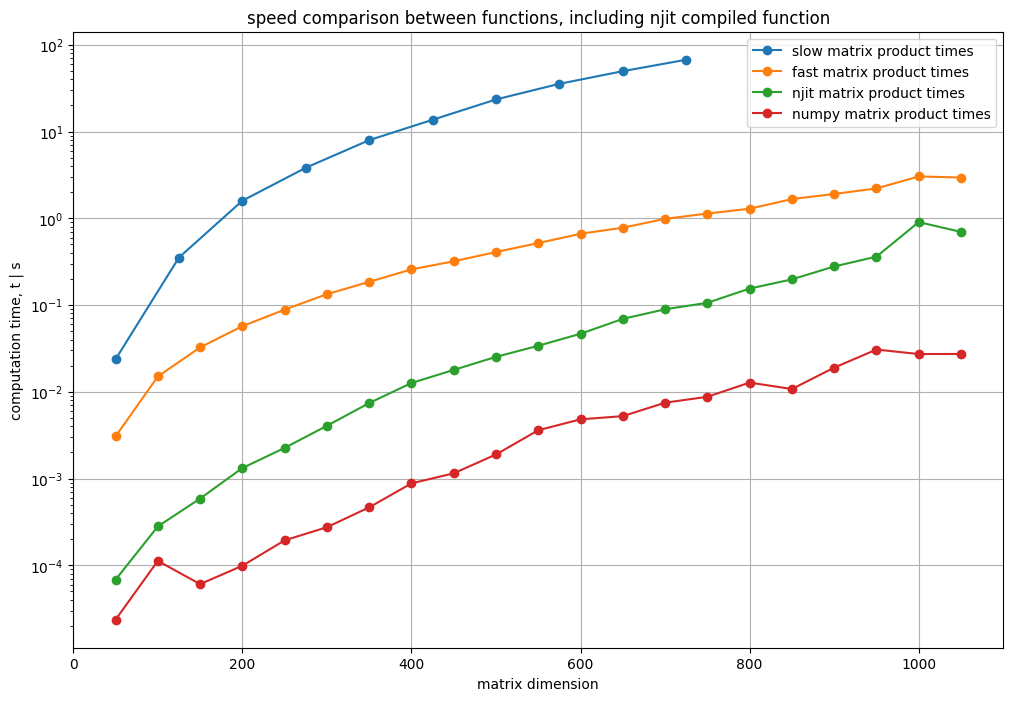

In [21]:
plt.figure(figsize=(12,8))
plt.title('speed comparison between functions, including njit compiled function')
plt.ylabel('computation time, t | s')
plt.xlabel('matrix dimension')

plt.plot(matrix_sizes, np.array(slow_times)/8, '-o', label='slow matrix product times')
plt.plot(matrix_sizes_2, np.array(fast_times_2)/8, '-o', label='fast matrix product times')
plt.plot(matrix_sizes_2, np.array(njit_times_2)/8, '-o', label='njit matrix product times')
plt.plot(matrix_sizes_2, np.array(numpy_times_2)/8, '-o', label='numpy matrix product times')

plt.grid()
plt.legend()
plt.yscale('log')

Here, the Numba JIT compiled function runs roughly an order of magnitude faster than the uncompiled function as Numba JIT compiling translates python into optimised machine code with the LLVM compiler. Doing this, as well as using `numba.prange` and specifying variable types at initial compiling, drastically reducing compute times.

## `part 3: comparing c-style and fortran-stye ordering`
It is more efficient to access memory that is close to previous accesses when looping through arrays - thus, it is expected that altering the ordering style of the matrices being multiplied would change the compute times of the function. C-style ordering is row-based, whereas Fortran-style ordering is column based. One would therefore expect to see a decrease in compute times if the respective orderings of matrix 1 and 2 to be C-style and Fortran-style, as loops will access contiguous memory for both matrices when ordered in such a way. 

In [22]:
cc_times = []
cf_times = []
fc_times = []
ff_times = []
numpy_times_3 = []

for i in tqdm(matrix_sizes_2):
    matrix1_c = np.random.rand(i,i)
    matrix2_c = np.random.rand(i,i)
    matrix1_f = np.asfortranarray(matrix1_c)
    matrix2_f = np.asfortranarray(matrix2_c)

    cc_times.append(timeit(lambda: faster_matrix_product_njit(matrix1_c, matrix2_c), globals=globals(), number=8))
    cf_times.append(timeit(lambda: faster_matrix_product_njit(matrix1_c, matrix2_f), globals=globals(), number=8))
    fc_times.append(timeit(lambda: faster_matrix_product_njit(matrix1_f, matrix2_c), globals=globals(), number=8))
    ff_times.append(timeit(lambda: faster_matrix_product_njit(matrix1_f, matrix2_f), globals=globals(), number=8))
    numpy_times_3.append(timeit(lambda: matrix1_c@matrix2_c, globals=globals(), number=8))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [04:01<00:00, 11.50s/it]


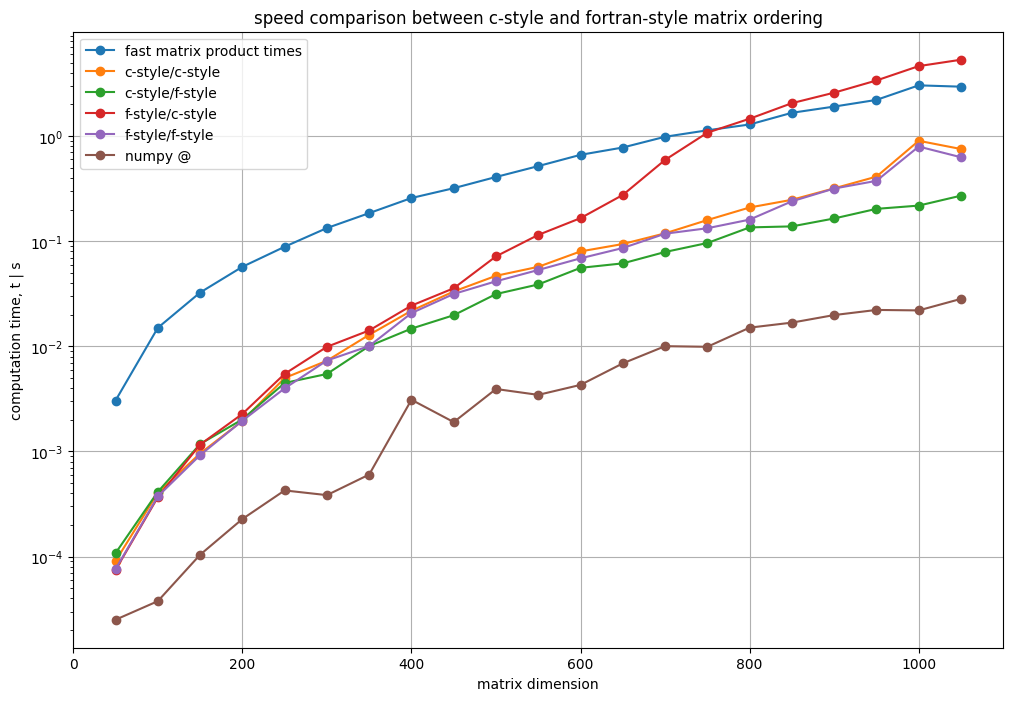

In [27]:
plt.figure(figsize=(12,8))
plt.title('speed comparison between c-style and fortran-style matrix ordering')
plt.ylabel('computation time, t | s')
plt.xlabel('matrix dimension')

plt.plot(matrix_sizes_2, np.array(fast_times_2)/8, '-o', label='fast matrix product times')
plt.plot(matrix_sizes_2, np.array(cc_times)/8, '-o', label='c-style/c-style')
plt.plot(matrix_sizes_2, np.array(cf_times)/8, '-o', label='c-style/f-style')
plt.plot(matrix_sizes_2, np.array(fc_times)/8, '-o', label='f-style/c-style')
plt.plot(matrix_sizes_2, np.array(ff_times)/8, '-o', label='f-style/f-style')
plt.plot(matrix_sizes_2, np.array(numpy_times_3)/8, '-o', label='numpy @')

plt.grid()
plt.legend()
plt.yscale('log')

As predicted, C-style ordering for matrix 1 and Fortran-style ordering for matrix 2 yields fastest computational time, as their orderings are row-based and column-based respectively. This means that the dot product in the loop accesses contiguous memory in both matrices, maximising cache efficiency and speeding up memory access. In contrast, fortran-style/c-style ordering has computation time that exceeds even the non-jit-compiled matrix product at high matrix dimensions, as for that ordering-style, the slices in the loops access non-contiguous elements, slowing down operations.